In [513]:
import medical_lib as ml
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sklearn import utils
import math
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import medical_lib as ml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [527]:
intervalle = [(0, 30), (31, 60), (61, 180),(181, 365), (366, 800), (801, 1650)]
df = pd.read_csv('model2_Classificationtable_intervalstatus_m6.csv')
df = df.iloc[:, 1:]
df = utils.shuffle(df, random_state=1)
df.reset_index(drop=True)
totdf = pd.read_csv('Verstorben.csv')
totdf = totdf.iloc[:, 1:]
unitot = totdf['Pseudonym'].unique()

Pro Intervall die Pseudonyme in ein Dataframe zwischenspeichern

In [568]:
def makeClassificationtablesM6(dataframe, uniquetote,left, right):
    dfintervalAll = dataframe[dataframe['relatives_datum'].between(left, right)]
    print(len(dfintervalAll))
    dfintervalTot = dfintervalAll[dfintervalAll['Pseudonym'].isin(uniquetote)]
    
    dfintervalLebend = dfintervalAll[~dfintervalAll['Pseudonym'].isin(uniquetote)]
    

    #80% der Toten für Training nehmen
    anzahl_train_tot = int(len(dfintervalTot) * 0.8)
    anzahl_train_lebend = int(len(dfintervalLebend) * 0.8)
    tot_train = dfintervalTot.iloc[0:(anzahl_train_tot+1), :]
    lebend_train = dfintervalLebend.iloc[0:(anzahl_train_lebend+1), :]
   
    #dementsprechent 20% der Toten für Predicten
    tot_test = dfintervalTot.iloc[anzahl_train_tot:-1, :]
    lebend_test = dfintervalLebend.iloc[anzahl_train_lebend:-1, :]

    train = pd.concat([tot_train, lebend_train])
    train = utils.shuffle(train, random_state=1)
    train.reset_index(drop=True)
    test = pd.concat([tot_test, lebend_test])
    test = utils.shuffle(test, random_state=1)
    test.reset_index(drop=True)
    
    return train, test

traindf, testdf = makeClassificationtablesM6(df, unitot, intervalle[5][0], intervalle[5][1])



221


In [569]:
train_features = traindf.iloc[:, 2:-1]
train_class = traindf.iloc[:, -1]
test_features = testdf.iloc[:, 2:-1]
test_class = testdf.iloc[:, -1]
test_class_array = test_class.to_numpy()
result = pd.read_csv('automated_algorithmen.csv')
result = result.iloc[:, 1:]
print(len(test_features))

43


Classification

KNN

In [578]:
#Für Intervall 5 muss Neighbours auf 2 gesetzt werden. Andernfalls teilt man durch 0
medKNN = KNeighborsClassifier(n_neighbors=2)
medKNN.fit(train_features,train_class)
knnYpred = medKNN.predict(test_features)
accuracyKNN = accuracy_score(test_class, knnYpred)
precisionKNN = precision_score(test_class, knnYpred, average='weighted')
recallKNN = recall_score(test_class, knnYpred, average='weighted')
f1scoreKNN = f1_score(test_class, knnYpred, average='weighted')
print('KNN Accuracy: ', accuracyKNN, 'KNN Precision: ', precisionKNN, 'KNN Recall: ', recallKNN, 'KNN F1-Score: ', f1scoreKNN )
pred_tot_lebendigknn = []
actual_tot_lebendigknn = []
abweichungknn = []
for el in range(0, len(knnYpred)):
    dist = abs(knnYpred[el] - test_class_array[el])
    abweichungknn.append(dist)
    if knnYpred[el] < 7:
        pred_tot_lebendigknn.append(1)
    else: 
        pred_tot_lebendigknn.append(0)
    if test_class_array[el] < 7:
        actual_tot_lebendigknn.append(1)
    else:
        actual_tot_lebendigknn.append(0)
accuracyknn, precisionknn, recallknn, f1scoreknn = ml.scoring(pred_tot_lebendigknn, actual_tot_lebendigknn)
print('Tatsächlich: ', accuracyknn, precisionknn, recallknn, f1scoreknn)
print('Durchschnittliche Abweichung: ', np.mean(abweichungknn))
print('Standartabweichung der Abweichung: ', np.std(abweichungknn))
index = result.index[result['Modellierung'] == 'Model_6_801_1650'].tolist()
result.at[index, 'KNN_precision'] = precisionknn
result.at[index, 'KNN_recall'] = recallknn
result.at[index, 'KNN_f1'] = f1scoreknn
result.to_csv('automated_algorithmen.csv')

KNN Accuracy:  0.9767441860465116 KNN Precision:  0.9844961240310078 KNN Recall:  0.9767441860465116 KNN F1-Score:  0.97892621303474
Tatsächlich:  0.9767441860465116 0.6666666666666666 1.0 0.8
Durchschnittliche Abweichung:  0.023255813953488372
Standartabweichung der Abweichung:  0.1507148999629735


In [571]:
lr_model = LogisticRegression()
lr_model.fit(train_features,train_class)
lr_y_pred = lr_model.predict(test_features)
lr_accuracyLogReg = accuracy_score(test_class, lr_y_pred)
lr_precisionLogReg = precision_score(test_class, lr_y_pred, average='weighted')
lr_recallLogReg = recall_score(test_class, lr_y_pred, average='weighted')
lr_f1scoreLogReg = f1_score(test_class, lr_y_pred, average='weighted')
print('Log-Regression Accuracy: ', lr_accuracyLogReg, 'Log-Regression Precision: ', lr_precisionLogReg, 'Log-Regression Recall: ', lr_recallLogReg, 'Log-Regression F1-Score: ', lr_f1scoreLogReg )
pred_tot_lebendiglr = []
actual_tot_lebendiglr = []
abweichunglr = []
for el in range(0, len(lr_y_pred)):
    dist = abs(lr_y_pred[el] - test_class_array[el])
    abweichunglr.append(dist)
    if lr_y_pred[el] < 7:
        pred_tot_lebendiglr.append(1)
    else: 
        pred_tot_lebendiglr.append(0)
    if test_class_array[el] < 7:
        actual_tot_lebendiglr.append(1)
    else:
        actual_tot_lebendiglr.append(0)
accuracylr, precisionlr, recalllr, f1scorelr = ml.scoring(pred_tot_lebendiglr, actual_tot_lebendiglr)
print('Tatsächlich: ', accuracylr, precisionlr, recalllr, f1scorelr)
print('Durchschnittliche Abweichung: ', np.mean(abweichunglr))
print('Standartabweichung der Abweichung: ', np.std(abweichunglr))
index = result.index[result['Modellierung'] == 'Model_6_801_1650'].tolist()
result.at[index, 'Logistic_Regression_precision'] = precisionlr
result.at[index, 'Logistic_Regression_recall'] = recalllr
result.at[index, 'Logistic_Regression_f1'] = f1scorelr
result.to_csv('automated_algorithmen.csv')

Log-Regression Accuracy:  0.9302325581395349 Log-Regression Precision:  0.9451550387596899 Log-Regression Recall:  0.9302325581395349 Log-Regression F1-Score:  0.9367786391042204
Tatsächlich:  0.9302325581395349 0.3333333333333333 0.5 0.4
Durchschnittliche Abweichung:  0.06976744186046512
Standartabweichung der Abweichung:  0.2547546779093796


In [572]:
medical_DecTree = DecisionTreeClassifier(random_state=15)
medical_DecTree = medical_DecTree.fit(train_features,train_class)
decTree_pred = medical_DecTree.predict(test_features)
accuracyDecTree = accuracy_score(test_class, decTree_pred)
precisionDecTree = precision_score(test_class, decTree_pred, average='weighted')
recallDecTree = recall_score(test_class, decTree_pred, average='weighted')
f1scoreDecTree = f1_score(test_class, decTree_pred, average='weighted')
print('medical_DecTree Accuracy: ', accuracyDecTree, 'DecTree Precision: ', precisionDecTree, 'DecTree Recall: ', recallDecTree, 'DecTree F1-Score: ', f1scoreDecTree )
pred_tot_lebendigdc = []
actual_tot_lebendigdc = []
abweichungdc = []
for el in range(0, len(decTree_pred)):
    dist = abs(decTree_pred[el] - test_class_array[el])
    abweichungdc.append(dist)
    if decTree_pred[el] < 7:
        pred_tot_lebendigdc.append(1)
    else: 
        pred_tot_lebendigdc.append(0)
    if test_class_array[el] < 7:
        actual_tot_lebendigdc.append(1)
    else:
        actual_tot_lebendigdc.append(0)
accuracydc, precisiondc, recalldc, f1scoredc = ml.scoring(pred_tot_lebendigdc, actual_tot_lebendigdc)
print('Tatsächlich: ', accuracydc, precisiondc, recalldc, f1scoredc)
print('Durchschnittliche Abweichung: ', np.mean(abweichungdc))
print('Standartabweichung der Abweichung: ', np.std(abweichungdc))
index = result.index[result['Modellierung'] == 'Model_6_801_1650'].tolist()
result.at[index, 'Decision_Tree_precision'] = precisiondc
result.at[index, 'Decision_Tree_recall'] = recalldc
result.at[index, 'Decision_Tree_f1'] = f1scoredc
result.to_csv('automated_algorithmen.csv')


medical_DecTree Accuracy:  0.9302325581395349 DecTree Precision:  0.9451550387596899 DecTree Recall:  0.9302325581395349 DecTree F1-Score:  0.9367786391042204
Tatsächlich:  0.9302325581395349 0.3333333333333333 0.5 0.4
Durchschnittliche Abweichung:  0.06976744186046512
Standartabweichung der Abweichung:  0.2547546779093796


In [573]:
medical_RF = RandomForestClassifier(random_state=43)
medical_RF.fit(train_features,train_class)
rfPred = medical_RF.predict(test_features)
accuracyRF = accuracy_score(test_class, rfPred)
precisionRF = precision_score(test_class, rfPred, average='weighted')
recallRF = recall_score(test_class, rfPred, average='weighted')
f1scoreRF = f1_score(test_class, rfPred, average='weighted')
print('Anzahl Estimator: 100 ', 'RF Accuracy: ', accuracyRF, 'RF Precision: ', precisionRF, 'RF Recall: ', recallRF, 'RF F1-Score: ', f1scoreRF )
pred_tot_lebendigrf = []
actual_tot_lebendigrf = []
abweichungrf = []
for el in range(0, len(rfPred)):
    dist = abs(rfPred[el] - test_class_array[el])
    abweichungrf.append(dist)
    if rfPred[el] < 7:
        pred_tot_lebendigrf.append(1)
    else: 
        pred_tot_lebendigrf.append(0)
    if test_class_array[el] < 7:
        actual_tot_lebendigrf.append(1)
    else:
        actual_tot_lebendigrf.append(0)
try:
    accuracyrf, precisionrf, recallrf, f1scorerf = ml.scoring(pred_tot_lebendigrf, actual_tot_lebendigrf)
except:
    precisionrf = 0
print('Tatsächlich: ', accuracyrf, precisionrf, recallrf, f1scorerf)
print('Durchschnittliche Abweichung: ', np.mean(abweichungrf))
print('Standartabweichung der Abweichung: ', np.std(abweichungrf))
index = result.index[result['Modellierung'] == 'Model_6_801_1650'].tolist()
result.at[index, 'Random_Forest_precision'] = precisionrf
result.at[index, 'Random_Forest_recall'] = recallrf
result.at[index, 'Random_Forest_f1'] = f1scorerf
result.to_csv('automated_algorithmen.csv')


Anzahl Estimator: 100  RF Accuracy:  0.9302325581395349 RF Precision:  0.9451550387596899 RF Recall:  0.9302325581395349 RF F1-Score:  0.9367786391042204
Tatsächlich:  0.9302325581395349 0.3333333333333333 0.5 0.4
Durchschnittliche Abweichung:  0.06976744186046512
Standartabweichung der Abweichung:  0.2547546779093796


In [574]:
adamodel = AdaBoostClassifier()
adamodel.fit(train_features,train_class)
adamodel_prediction = adamodel.predict(test_features)
adamodel_accuracy = accuracy_score(test_class, adamodel_prediction)
adamodel_precision = precision_score(test_class, adamodel_prediction, average='weighted')
adamodel_recall = recall_score(test_class, adamodel_prediction, average='weighted')
adamodel_f1 = f1_score(test_class, adamodel_prediction, average='weighted')
print('ADABOOST: ', 'Accuracy: ', adamodel_accuracy,'Precision: ', adamodel_precision,'Recall: ', adamodel_recall,'f1-Score: ', adamodel_f1)
pred_tot_lebendigada = []
actual_tot_lebendigada = []
abweichungada = []
for el in range(0, len(adamodel_prediction)):
    dist = abs(adamodel_prediction[el] - test_class_array[el])
    abweichungada.append(dist)
    if adamodel_prediction[el] < 7:
        pred_tot_lebendigada.append(1)
    else: 
        pred_tot_lebendigada.append(0)
    if test_class_array[el] < 7:
        actual_tot_lebendigada.append(1)
    else:
        actual_tot_lebendigada.append(0)
accuracyada, precisionada, recallada, f1scoreada = ml.scoring(pred_tot_lebendigada, actual_tot_lebendigada)
print('Tatsächlich: ', accuracyada, precisionada, recallada, f1scoreada)
print('Durchschnittliche Abweichung: ', np.mean(abweichungada))
print('Standartabweichung der Abweichung: ', np.std(abweichungada))
index = result.index[result['Modellierung'] == 'Model_6_801_1650'].tolist()
result.at[index, 'ADABoost_precision'] = precisionada
result.at[index, 'ADABoost_recall'] = recallada
result.at[index, 'ADABoost_f1'] = f1scoreada
result.to_csv('automated_algorithmen.csv')

ADABOOST:  Accuracy:  0.9534883720930233 Precision:  0.9534883720930233 Recall:  0.9534883720930233 f1-Score:  0.9534883720930233
Tatsächlich:  0.9534883720930233 0.5 0.5 0.5
Durchschnittliche Abweichung:  0.046511627906976744
Standartabweichung der Abweichung:  0.21059035204970736


In [575]:
xgmodel = XGBClassifier(eval_metric='error')
xgmodel.fit(train_features,train_class)
xgboosted_prediction = xgmodel.predict(test_features)
xgboosted_accuracy = accuracy_score(test_class, xgboosted_prediction)
xgboosted_precision = precision_score(test_class, xgboosted_prediction, average='weighted')
xgboosted_recall = recall_score(test_class, xgboosted_prediction, average='weighted')
xgboosted_f1 = f1_score(test_class, xgboosted_prediction, average='weighted')
print('XGBOOST: ', 'Accuracy: ', xgboosted_accuracy, 'Precision: ', xgboosted_precision, 'Recall: ', xgboosted_recall, 'F1-Score: ', xgboosted_f1)
pred_tot_lebendigxg = []
actual_tot_lebendigxg = []
abweichungxg = []
for el in range(0, len(xgboosted_prediction)):
    dist = abs(xgboosted_prediction[el] - test_class_array[el])
    abweichungxg.append(dist)
    if xgboosted_prediction[el] < 7:
        pred_tot_lebendigxg.append(1)
    else: 
        pred_tot_lebendigxg.append(0)
    if test_class_array[el] < 7:
        actual_tot_lebendigxg.append(1)
    else:
        actual_tot_lebendigxg.append(0)
accuracyxg, precisionxg, recallxg, f1scorexg = ml.scoring(pred_tot_lebendigxg, actual_tot_lebendigxg)
print('Tatsächlich: ', accuracyxg, precisionxg, recallxg, f1scorexg)
print('Durchschnittliche Abweichung: ', np.mean(abweichungxg))
print('Standartabweichung der Abweichung: ', np.std(abweichungxg))
print('#################################################################################################')
index = result.index[result['Modellierung'] == 'Model_6_801_1650'].tolist()
result.at[index, 'XGBoost_precision'] = precisionxg
result.at[index, 'XGBoost_recall'] = recallxg
result.at[index, 'XGBoost_f1'] = f1scorexg
result.to_csv('automated_algorithmen.csv')

XGBOOST:  Accuracy:  0.9534883720930233 Precision:  0.9534883720930233 Recall:  0.9534883720930233 F1-Score:  0.9534883720930233
Tatsächlich:  0.9534883720930233 0.5 0.5 0.5
Durchschnittliche Abweichung:  0.046511627906976744
Standartabweichung der Abweichung:  0.21059035204970736
#################################################################################################


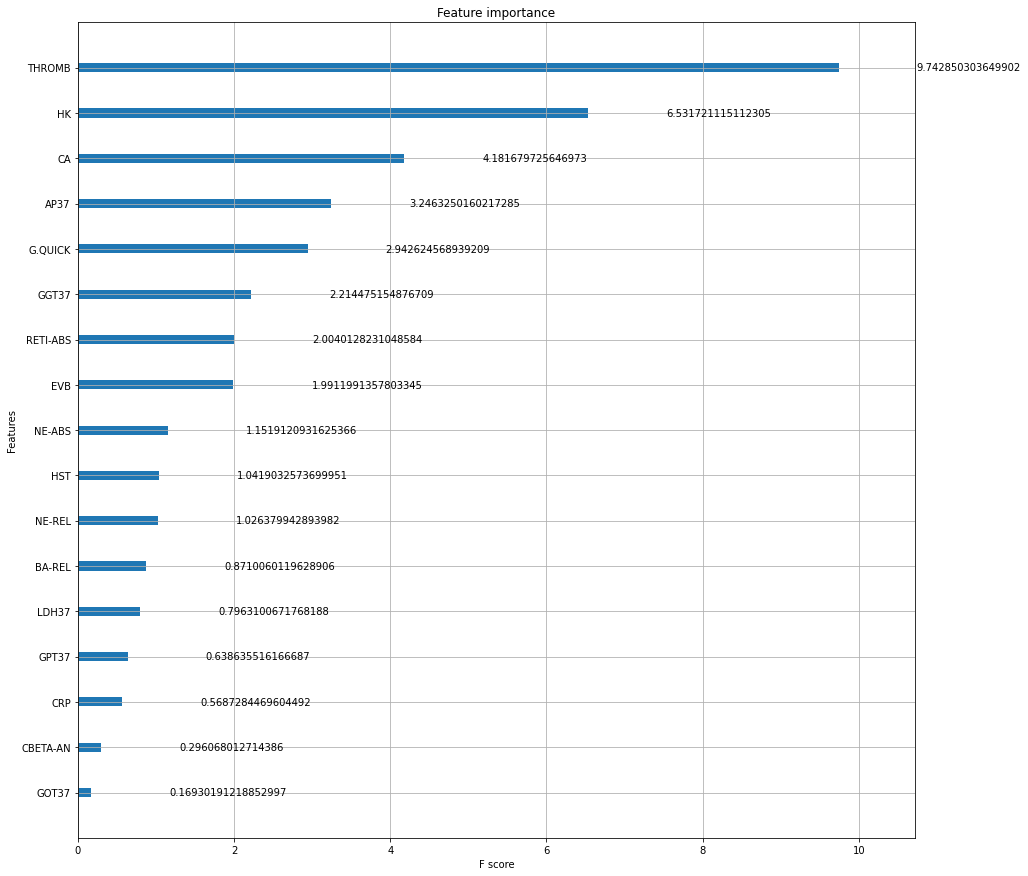

In [576]:
featureranking = sorted((value, key) for (key, value) in xgmodel.get_booster().get_score(importance_type = 'gain').items())
pyplot.rcParams['figure.figsize'] = [15,15]
newfeatures = []
plot_importance(xgmodel.get_booster().get_score(importance_type= 'gain'))
pyplot.show()

Nach Feature-Selection: Einlesen der Daten